In [1]:
import pandas as pd
import os
import datetime
from datetime import timedelta
from tqdm import tqdm_notebook
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path=os.path.join('/','home', 'fterroso', 'data', 'Spain-INE-mobility-study-2020', 'muestra1')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')
e_date = datetime.datetime.strptime('2021-04-30', '%Y-%m-%d')

In [3]:
def generate_days_fn(init_date, final_date):
    
    delta = final_date - init_date       # as timedelta

    target_days = []
    for i in range(delta.days + 1):
        day = init_date + timedelta(days=i)
        target_days.append(day)
    
    return target_days

In [4]:
def generate_list_of_files(data_path_,init_date, final_date):
    dates = generate_days_fn(init_date, final_date)
    files_lst=[]
    for d in dates:
        date_str= d.strftime('%Y%m%d')
        #year_month_str = date_.strftime('%Y%m')
        files_lst.append(os.path.join(data_path, f'{date_str}_maestra_1_mitma_distrito.txt'))
    return files_lst

In [5]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=5, n_workers=20)
client

Client Scheduler: tcp://127.0.0.1:33372 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 20 Cores: 100 Memory: 135.09 GB


## Read raw mobility files

In [6]:
files_to_read = generate_list_of_files(data_path, i_date, e_date)

In [7]:
df = dd.read_csv(files_to_read, sep='|',dtype={'origen':str, 'destino':str,'fecha':str, 'periodo':str})

In [8]:
df

,fecha,origen,destino,actividad_origen,actividad_destino,residencia,edad,periodo,distancia,viajes,viajes_km
npartitions=2187,,,,,,,,,,,
,object,object,object,object,object,int64,float64,object,object,float64,float64
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [9]:
df.head()

,fecha,origen,destino,actividad_origen,actividad_destino,residencia,edad,periodo,distancia,viajes,viajes_km
0,20200401,01001_AM,01001_AM,casa,otros,1,NaN,00,002-005,11.424,42.976
1,20200401,01001_AM,01001_AM,casa,otros,1,NaN,00,005-010,18.845,132.361
2,20200401,01001_AM,01001_AM,casa,otros,1,NaN,00,010-050,7.421,92.181
3,20200401,01001_AM,01001_AM,casa,otros,1,NaN,03,002-005,11.424,32.341
4,20200401,01001_AM,01001_AM,casa,otros,1,NaN,03,005-010,17.463,103.251


## Generate touristic flows 

### Others - others

In [10]:
flow_oo=df[(df['actividad_origen']=='otros') & 
           (df['actividad_destino']=='otros') & 
           (df['distancia']=='100+')].compute()
flow_oo

,fecha,origen,destino,actividad_origen,actividad_destino,residencia,edad,periodo,distancia,viajes,viajes_km
697,20200401,01001_AM,09056,otros,otros,20,NaN,05,100+,10.800,1092.902
698,20200401,01001_AM,0905903,otros,otros,20,NaN,09,100+,18.340,2355.381
700,20200401,01001_AM,0905909,otros,otros,21,NaN,13,100+,9.137,1030.231
703,20200401,01001_AM,09194_AM,otros,otros,28,NaN,03,100+,6.421,1047.901
704,20200401,01001_AM,09194_AM,otros,otros,30,NaN,02,100+,4.558,755.392
...,...,...,...,...,...,...,...,...,...,...,...
636463,20210430,5200108,29082_AM,otros,otros,10,NaN,17,100+,11.829,2369.095
636465,20210430,5200108,2909404,otros,otros,52,NaN,00,100+,6.542,1265.373
636466,20210430,5200108,4100404_AD,otros,otros,52,NaN,14,100+,6.542,2267.083
636467,20210430,5200108,41036_AM,otros,otros,52,NaN,14,100+,7.226,2255.744


In [ ]:
flow_oo[flow_oo['origen']=='02003007']

In [21]:
i_date_str= i_date.strftime('%Y%m%d')
e_date_str= e_date.strftime('%Y%m%d')

In [12]:
flow_oo.to_csv(os.path.join('data','mobility', f'flow_oo_{i_date_str}_{e_date_str}.csv'))

### Home - others

In [13]:
flow_ho=df[(df['actividad_origen']=='casa') & 
           (df['actividad_destino']=='otros') & 
           (df['distancia']=='100+')].compute()
flow_ho

,fecha,origen,destino,actividad_origen,actividad_destino,residencia,edad,periodo,distancia,viajes,viajes_km
699,20200401,01001_AM,0905909,casa,otros,1,NaN,16,100+,7.309,816.875
701,20200401,01001_AM,09194_AM,casa,otros,1,NaN,15,100+,10.933,1805.204
702,20200401,01001_AM,09194_AM,casa,otros,1,NaN,21,100+,9.258,1402.821
708,20200401,01001_AM,12140_AM,casa,otros,1,NaN,19,100+,10.933,3804.635
730,20200401,01001_AM,21040_AM,casa,otros,1,NaN,00,100+,10.392,7275.762
...,...,...,...,...,...,...,...,...,...,...,...
636452,20210430,5200108,2906711,casa,otros,52,NaN,17,100+,6.542,1334.131
636461,20210430,5200108,29072,casa,otros,52,NaN,17,100+,6.542,1678.911
636464,20210430,5200108,29084_AM,casa,otros,52,NaN,14,100+,6.542,1683.356
636468,20210430,5200108,4109108,casa,otros,52,NaN,14,100+,6.542,2357.431


In [14]:
flow_ho.to_csv(os.path.join('data','mobility', f'flow_ho_{i_date_str}_{e_date_str}.csv'))

### Others - home

In [15]:
flow_oh=df[(df['actividad_origen']=='otros') & 
           (df['actividad_destino']=='casa') & 
           (df['distancia']=='100+')].compute()
flow_oh

,fecha,origen,destino,actividad_origen,actividad_destino,residencia,edad,periodo,distancia,viajes,viajes_km
696,20200401,01001_AM,06060_AM,otros,casa,6,NaN,22,100+,3.841,2084.471
803,20200401,01001_AM,39091_AM,otros,casa,39,NaN,09,100+,8.138,1270.895
806,20200401,01001_AM,47071_AM,otros,casa,47,NaN,19,100+,4.421,1204.278
2064,20200401,01031_AM,2811301,otros,casa,28,NaN,18,100+,8.325,2335.417
2398,20200401,01036,0905905,otros,casa,9,NaN,18,100+,8.624,891.434
...,...,...,...,...,...,...,...,...,...,...,...
636433,20210430,5200108,29012,otros,casa,29,NaN,17,100+,13.108,3049.362
636441,20210430,5200108,2906707,otros,casa,29,NaN,17,100+,5.372,1114.551
636460,20210430,5200108,2906902,otros,casa,29,NaN,17,100+,6.318,1441.490
636462,20210430,5200108,29082_AM,otros,casa,29,NaN,16,100+,7.465,1478.830


In [16]:
flow_oh.to_csv(os.path.join('data','mobility', f'flow_oh_{i_date_str}_{e_date_str}.csv'))

## Generate regular human flows

In [26]:
reg_flow=df[((df['actividad_origen']=='casa') |
            (df['actividad_origen']=='trabajo')) & 
           ((df['actividad_destino']=='casa') | 
            (df['actividad_destino']=='trabajo'))].compute()
reg_flow.head()

distributed.nanny - WARNING - Restarting worker


,fecha,origen,destino,actividad_origen,actividad_destino,residencia,edad,periodo,distancia,viajes,viajes_km
48,20200401,01001_AM,01001_AM,casa,trabajo,1,NaN,08,010-050,8.261,101.423
49,20200401,01001_AM,01001_AM,casa,trabajo,1,NaN,14,005-010,7.910,51.016
50,20200401,01001_AM,01001_AM,casa,trabajo,1,NaN,20,005-010,5.291,47.549
143,20200401,01001_AM,01001_AM,trabajo,casa,1,NaN,03,005-010,9.553,66.283
144,20200401,01001_AM,01001_AM,trabajo,casa,1,NaN,05,005-010,5.291,27.442
...,...,...,...,...,...,...,...,...,...,...,...
637921,20210430,5200108,5200108,trabajo,casa,52,NaN,21,002-005,12.086,25.205
637922,20210430,5200108,5200108,trabajo,casa,52,NaN,22,0005-002,84.602,99.029
637923,20210430,5200108,5200108,trabajo,casa,52,NaN,22,002-005,24.172,64.406
637924,20210430,5200108,5200108,trabajo,casa,52,NaN,23,0005-002,72.516,65.946


In [27]:
reg_flow.to_csv(os.path.join('data','mobility', f'reg_flow_{i_date_str}_{e_date_str}.csv'))

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - ERROR - Nanny failed to start process
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/nanny.py", line 575, in start
    await self.process.start()
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 202, in _start
    process.start()
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/context.py", line 284, in _Popen
    return Popen(process_obj)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/popen_spawn_posix.py", line 32, in __init__
    super().__init__(proce

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worke

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in termina

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distribu

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Restarting worker
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/m

distributed.nanny - WARNING - Restarting worker
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/m

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kw

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - ERROR - Nanny failed to start process
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/nanny.py", line 575, in start
    await self.process.start()
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwa

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
distributed.nanny - WARNING - Worker exceeded 95% memory budget. RestartingFuture exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminat

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
Future exception was never retrieved
future: <Future finished exception=AttributeError("'NoneType' object has no attribute 'terminate'",)>
Traceback (most recent call last):
  File "/home/fterroso/python/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/home/fterroso/python/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attr

## Plot all timeseries

In [70]:
def set_timestamp_index(ts):
    ts = ts.reset_index()
    ts['timestamp']= ts['fecha'].apply(lambda d: datetime.datetime.strptime(f'{d}', '%Y%m%d'))
    ts= ts.set_index('timestamp')
    ts = ts.drop(columns='fecha'.split())
    return ts

In [67]:
oo_ts = flow_oo.groupby('fecha')['viajes'].sum().to_frame()
oo_ts = set_timestamp_index(oo_ts) 

ho_ts = flow_ho.groupby('fecha')['viajes'].sum().to_frame()
ho_ts = set_timestamp_index(ho_ts)   

oh_ts = flow_oh.groupby('fecha')['viajes'].sum().to_frame()
oh_ts = set_timestamp_index(oh_ts)                        


Index(['fecha', 'viajes'], dtype='object')
Index(['fecha', 'viajes'], dtype='object')
Index(['fecha', 'viajes'], dtype='object')


In [68]:
oo_ts

,viajes
timestamp,
2020-04-01,200710.159
2020-04-02,206242.496
2020-04-03,176885.003
2020-04-04,65900.886
2020-04-05,51887.401
...,...
2021-04-26,425371.714
2021-04-27,421437.838
2021-04-28,433327.375


In [71]:
flow_wh_ts = set_timestamp_index(g_flow_wh)

KeyError: 'fecha'

In [72]:
flow_hw_ts = set_timestamp_index(g_flow_hw)

In [73]:
flow_hw_ts.head()

,viajes
timestamp,
2020-04-01,1439678.129
2020-04-02,1443118.972
2020-04-03,1472457.169
2020-04-04,1266683.361
2020-04-05,1122125.935


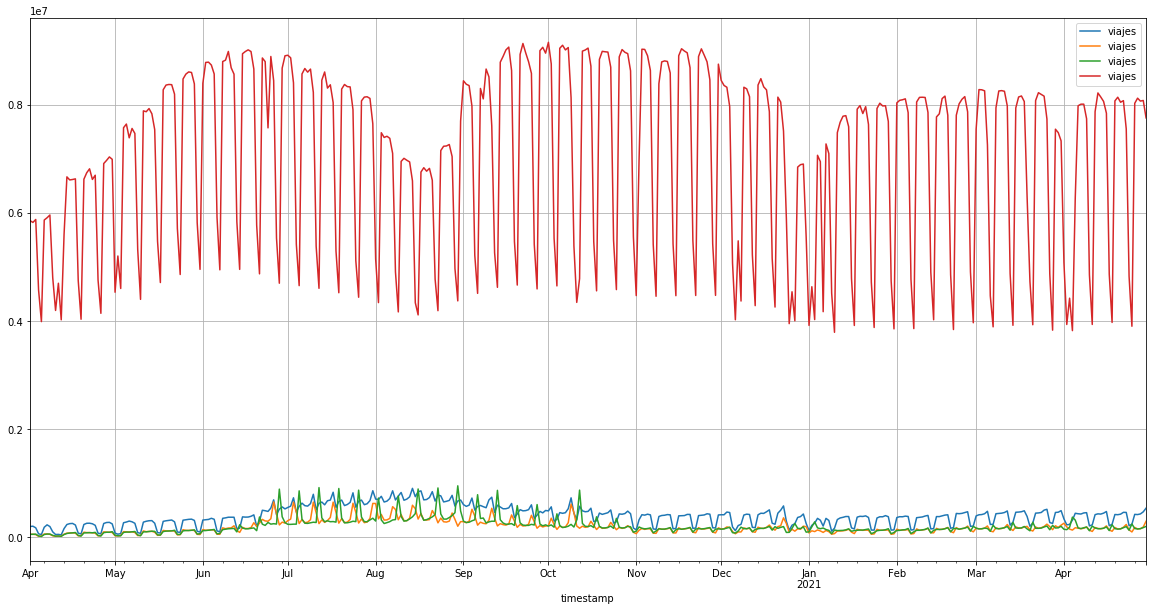

In [74]:
ax= oo_ts.plot( label='oo', legend=True, figsize=(20,10));
ho_ts.plot(ax=ax, label='ho', legend=True);
oh_ts.plot(ax=ax, label='oh', legend=True);
#g_flow_hw.plot(ax=ax, label='hw', legend=True);
g_flow_wh.plot(grid=True, ax=ax, label='wh', legend=True);

### Decompose series

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [77]:
def plot_decomposition(ts):
    result_ = seasonal_decompose(ts, model='additive', freq=7);

    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
    result_.trend.plot(ax=ax1, grid=True, fontsize=20)
    ax1.set_title('Trend',fontdict={'fontsize':20})

    result_.resid.plot(ax=ax2, grid=True, fontsize=20)
    ax2.set_title('Residuals',fontdict={'fontsize':20})

    result_.seasonal.plot(ax=ax3, grid=True, fontsize=20);
    ax3.set_title('Seasonal',fontdict={'fontsize':20})
    ax3.set_xlabel('Day', fontsize=20)

    plt.tight_layout()

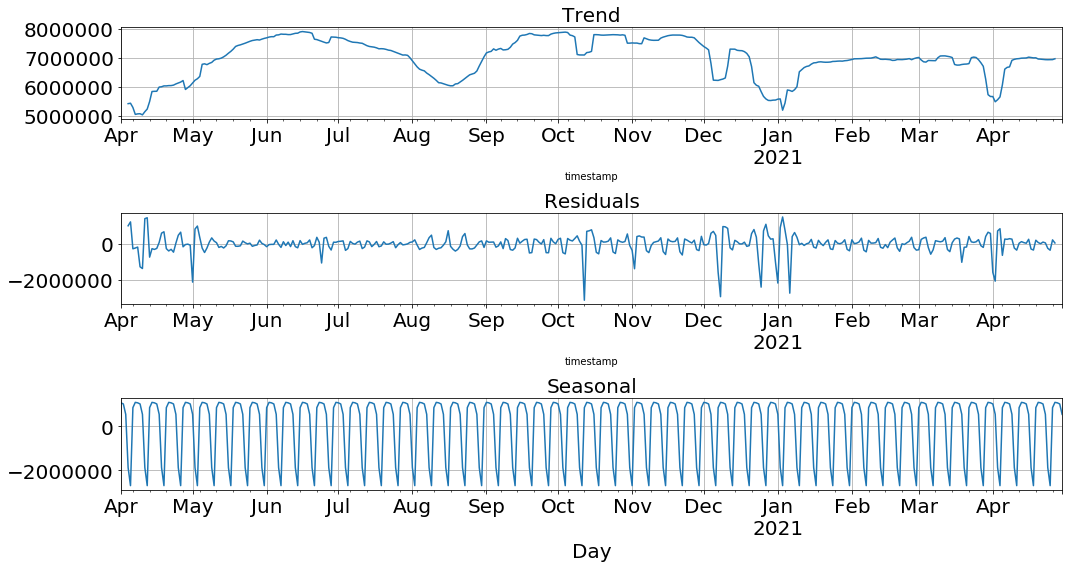

In [78]:
plot_decomposition(g_flow_wh)

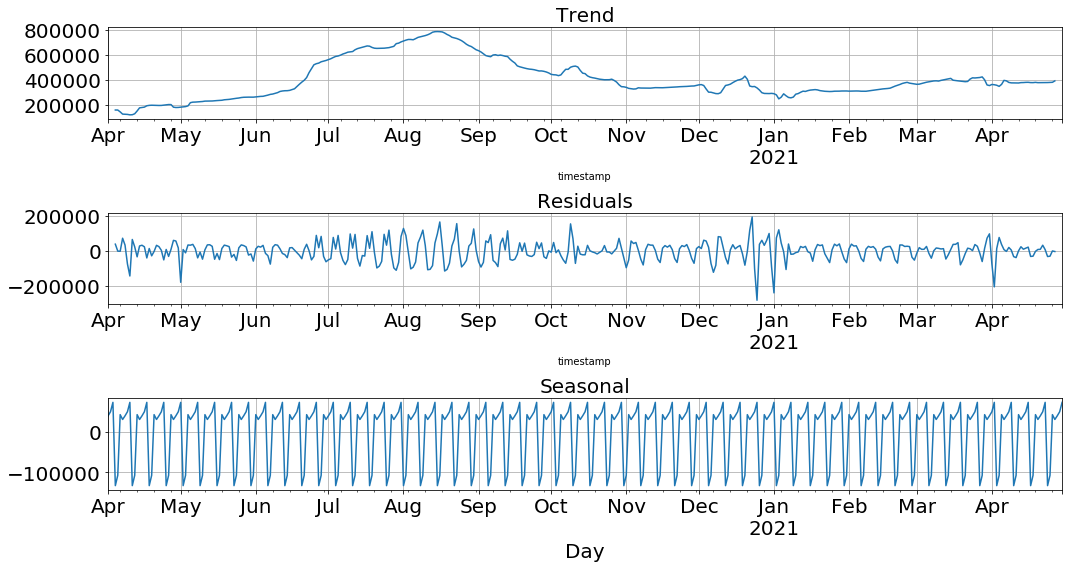

In [79]:
plot_decomposition(oo_ts)

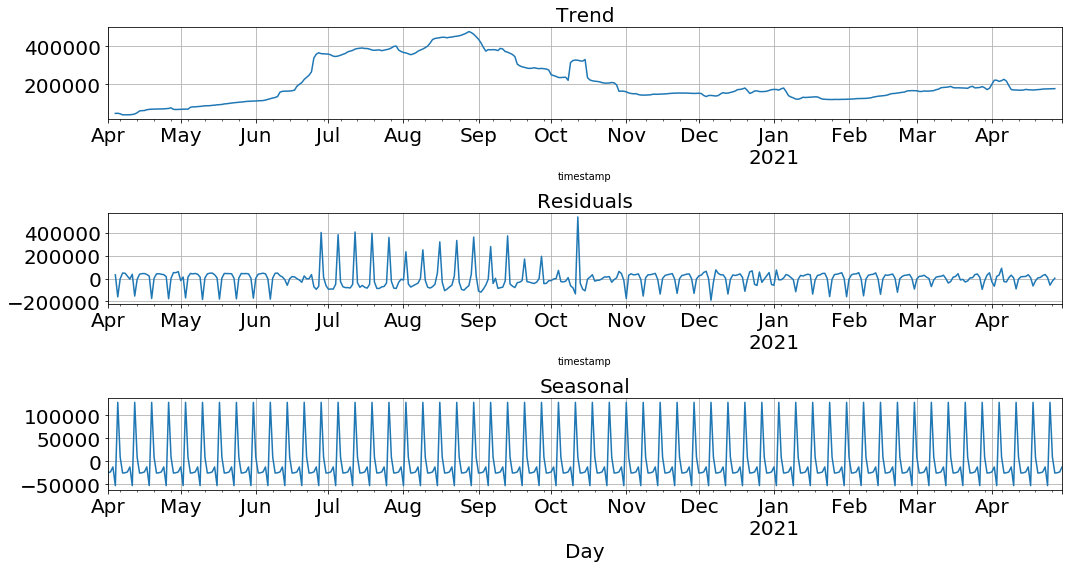

In [80]:
plot_decomposition(oh_ts)

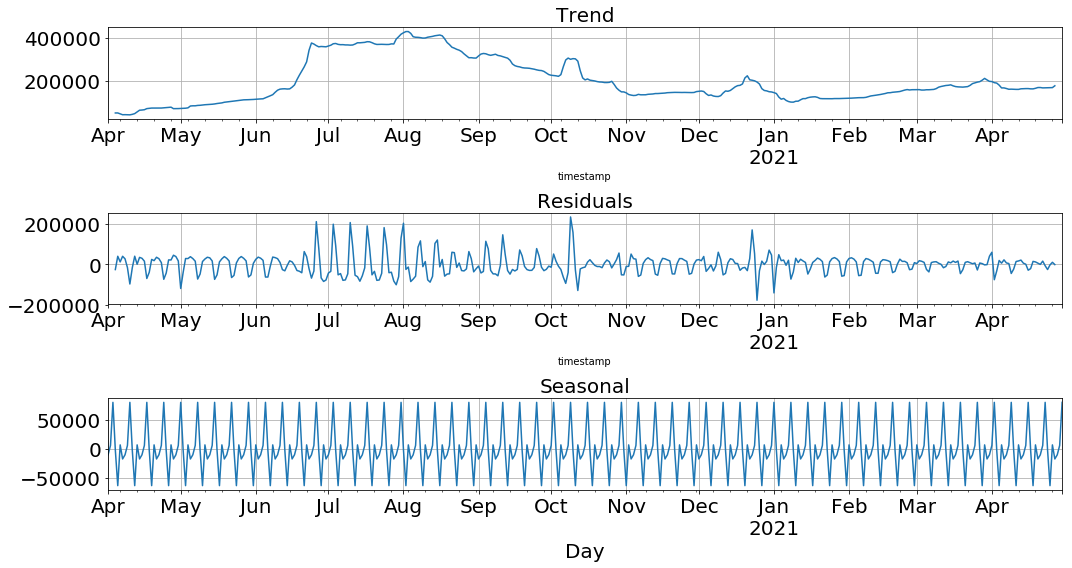

In [81]:
plot_decomposition(ho_ts)

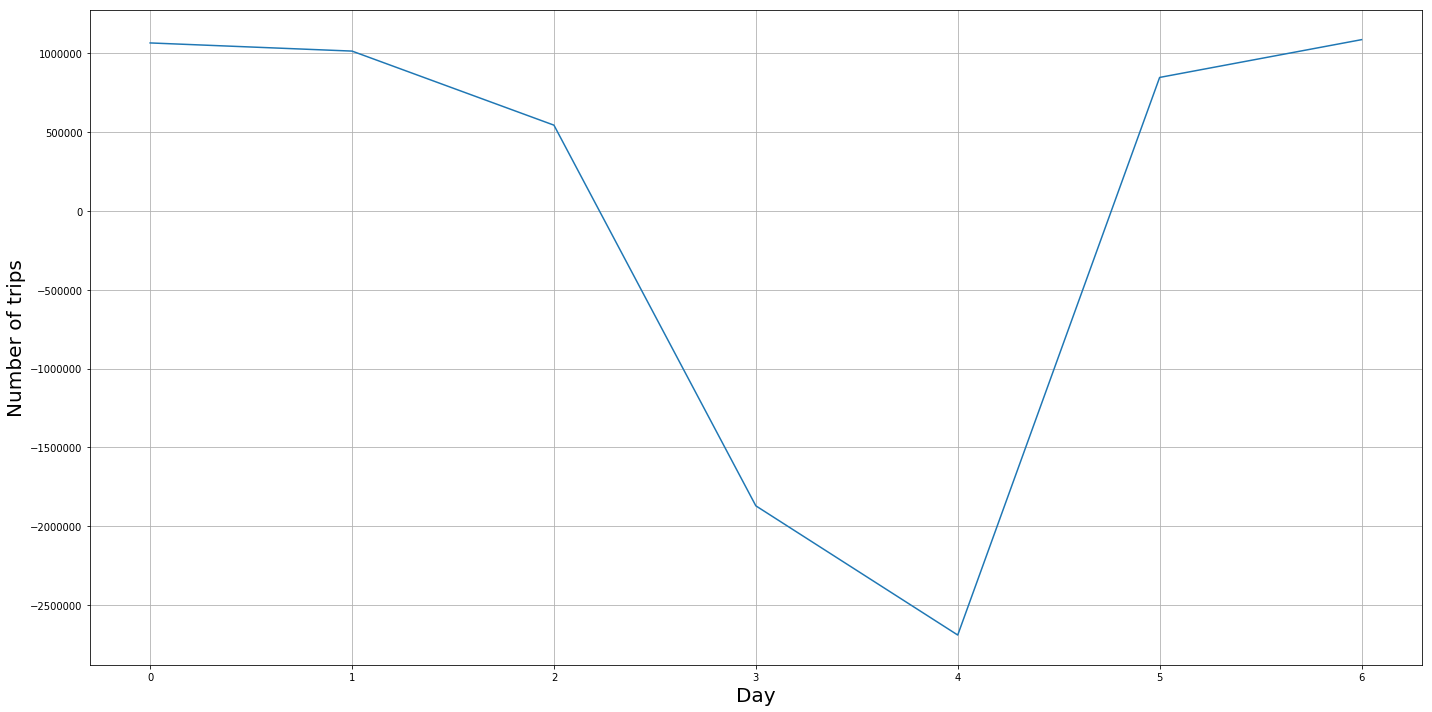

In [88]:

ax.set_xlabel('Day', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
plt.tight_layout()

In [92]:
result_wh = seasonal_decompose(g_flow_wh, model='additive', freq=7);
seasonal_wh= result_wh.seasonal.to_frame()
#ax= seasonal_.reset_index()[:7]['seasonal'].plot(figsize=(20,10), grid=True);

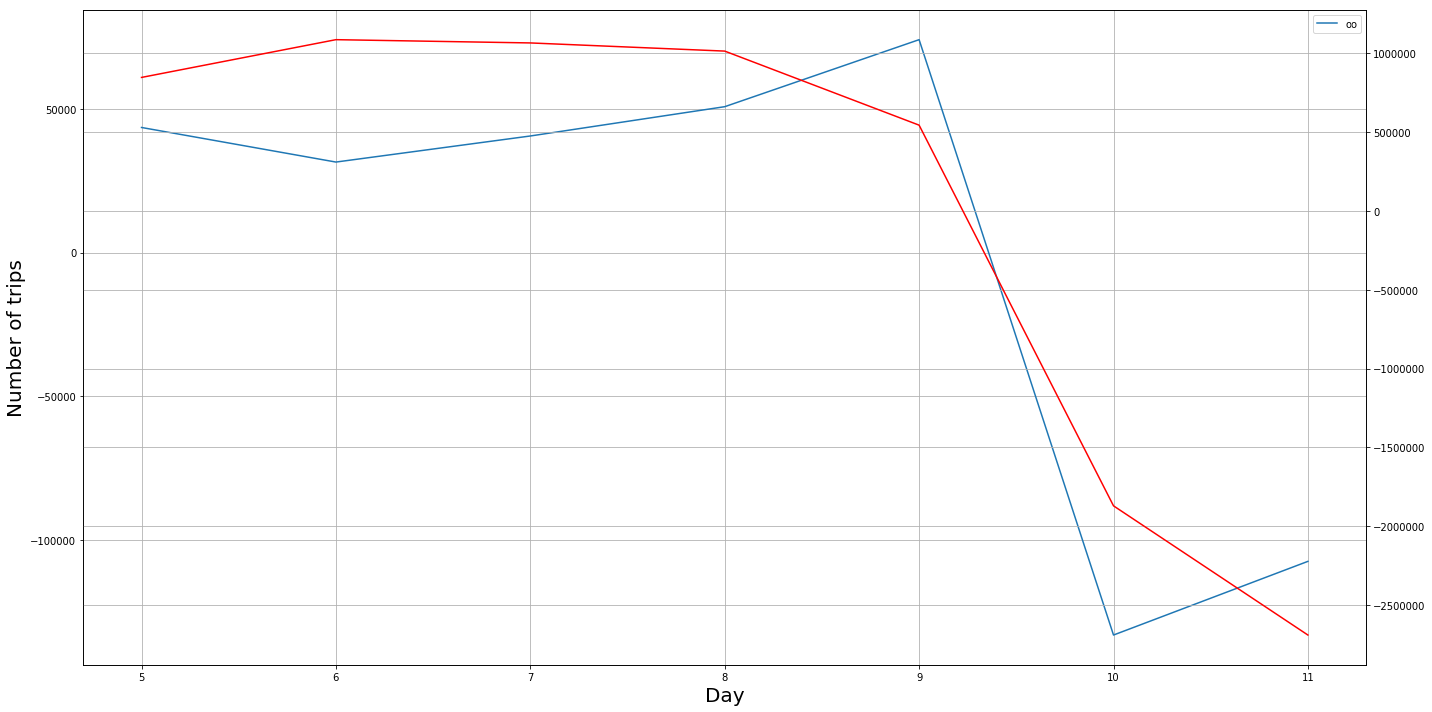

In [98]:
result_oo = seasonal_decompose(oo_ts, model='additive', freq=7);
seasonal_oo= result_oo.seasonal.to_frame()
ax= seasonal_oo.reset_index()[5:12]['seasonal'].plot(figsize=(20,10), grid=True, label='oo', legend=True);
ax2= ax.twinx()

seasonal_wh.reset_index()[5:12]['seasonal'].plot(ax=ax2,grid=True, color='red', label='wh');
ax.set_xlabel('Day', fontsize=20)
ax.set_ylabel('Number of trips (other-other)', fontsize=20)
ax.set_ylabel('Number of trips (work-home)', fontsize=20)

plt.tight_layout()

In [ ]:
print("That's all folks!")